<a href="https://colab.research.google.com/github/Ritacheta/PyTorch/blob/main/Pytorch_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip

 98% 1.12G/1.14G [00:15<00:00, 65.5MB/s]
100% 1.14G/1.14G [00:15<00:00, 80.1MB/s]


In [ ]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/COVID-19 Radiography Database', transform=Compose([Resize((224,224)),ToTensor()]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x],32, shuffle=True, num_workers=4) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

3886
2914
972
Dataset ImageFolder
    Number of datapoints: 3886
    Root location: /content/COVID-19 Radiography Database
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
torch.Size([32, 3, 224, 224]) torch.Size([32])


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.ImageFolder(root='/content/COVID-19 Radiography Database', #train=True, 
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.ImageFolder(root='/content/COVID-19 Radiography Database', 
                                          # train=False, download=True, 
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# change the number of classes 
vgg16.classifier[6].out_features = 3
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

In [ ]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(5):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0189, Train Acc: 84.56
Val Loss: 0.0040, Train Acc: 95.50
Train Loss: 0.0040, Train Acc: 95.39
Val Loss: 0.0033, Train Acc: 96.06
Train Loss: 0.0030, Train Acc: 96.58
Val Loss: 0.0016, Train Acc: 98.33
Train Loss: 0.0020, Train Acc: 97.76
Val Loss: 0.0010, Train Acc: 98.92
Train Loss: 0.0017, Train Acc: 98.30
Val Loss: 0.0008, Train Acc: 99.15
12.730728383858999 minutes


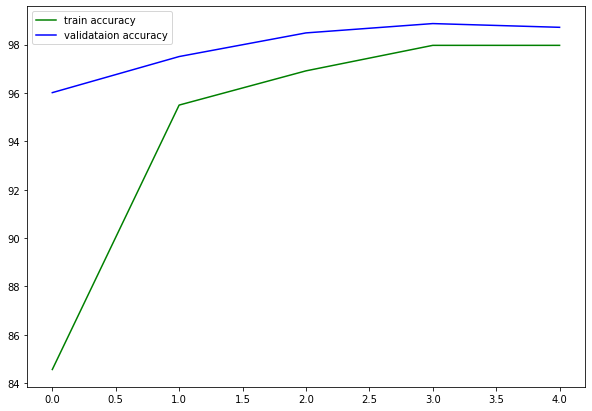

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

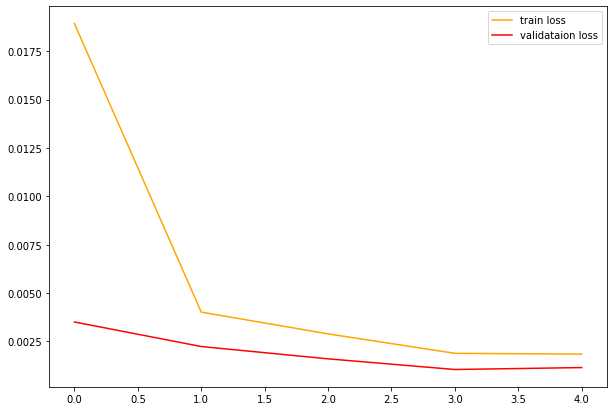

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()